# SVM implementation

### Library imports

In [1]:
# General Libraries
import pandas as pd
import numpy as np
import re
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Miscellaneous
import joblib
import copy
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Load and explore dataset

In [2]:
# Define the path to your dataset
data_path = 'normalized_and_tokenized_combined_data.xlsx'

# Load the dataset
df = pd.read_excel(data_path)

print("First few rows of the dataset:")
print(df.head())

print("\nData types of each column:")
print(df.dtypes)

print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nNumber of duplicated rows:", df.duplicated().sum())

df = df.drop_duplicates()
print("Dataset shape after removing duplicates:", df.shape)

First few rows of the dataset:
     id                                              title  \
0   526   یوٹیلیٹی اسٹورز پر چینی کی قیمت میں کمی کردی گئی   
1  1462            ایڈیلیڈ میچ کے ہیرو حارث رؤف کی سالگرہ   
2  1515  ’’پیگماٹائٹ‘‘ یہ نایاب پتھروں اور غیرمعمولی عن...   
3  1656  جوبائیڈن کا ڈونلڈ ٹرمپ کو فون، جیت پر مبارک با...   
4  1840             پاکستان میں آج سونے کی قیمت کیا رہی ؟   

                                 link  \
0  https://urdu.geo.tv/latest/385946-   
1    https://jang.com.pk/news/1409128   
2    https://jang.com.pk/news/1309594   
3    https://jang.com.pk/news/1408469   
4    https://urdu.samaa.tv/2087324435   

                                             content          gold_label  \
0  اسلام آباد: یوٹیلیٹی اسٹورز کارپوریشن نے چینی...            business   
1  قومی کرکٹ ٹیم کے فاسٹ بولر اور آسٹریلیا کے خل...              sports   
2  نایاب پتھروں یا انمول نگینوں کی تلاش اور پھر ح...  science-technology   
3  امریکی صدر جوبائیڈن نے ری پبلکن پارٹی کے ا

### Data preprocessing:

#### (i) Normalizing:

In [3]:
def normalize_text(text):
    """
    Normalize Urdu text by:
    - Converting to lowercase
    - Removing punctuation
    - Removing numbers
    - Removing extra whitespace
    """
    # Convert to string (in case of any non-string entries)
    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

#### (ii) Tokenizing:

In [4]:
def tokenize_text(text):
    """
    Tokenize the normalized text into words.
    """
    # Split text by whitespace
    tokens = text.split()

    # Remove stopwords (common words that are not useful for classification)
    # this is a smaller set of stopwords, we have uploaded another larger list on the GitHub
    # which is more comprehensive
    stopwords_urdu = set([
        'اور', 'میں', 'کو', 'کا', 'کی', 'کیوں', 'ہو', 'ہیں', 'ہوں', 'یہ', 'وہ',
        'وہاں', 'تھا', 'تھی', 'تھے', 'کر', 'کرنے',
        'کیا', 'ہوتا', 'ہوتی', 'ہوتے', 'گا', 'گی', 'گے', 'جائے', 'جانا'
    ])

    tokens = [token for token in tokens if token not in stopwords_urdu]

    return tokens

#### Apply normalization and tokenization:

In [5]:
# Apply normalization
df['normalized_content'] = df['content'].apply(normalize_text)

# Apply tokenization
df['processed_content'] = df['normalized_content'].apply(tokenize_text)

# Verify the preprocessing
print("\nSample of processed content:")
print(df[['content', 'processed_content']].head())


Sample of processed content:
                                             content  \
0  اسلام آباد: یوٹیلیٹی اسٹورز کارپوریشن نے چینی...   
1  قومی کرکٹ ٹیم کے فاسٹ بولر اور آسٹریلیا کے خل...   
2  نایاب پتھروں یا انمول نگینوں کی تلاش اور پھر ح...   
3  امریکی صدر جوبائیڈن نے ری پبلکن پارٹی کے امیدو...   
4  عالمی منڈی اور پاکستان بھر میں آج سونے کی قیم...   

                                   processed_content  
0  [اسلام, آباد, یوٹیلیٹی, اسٹورز, کارپوریشن, نے...  
1  [قومی, کرکٹ, ٹیم, کے, فاسٹ, بولر, آسٹریلیا, ک...  
2  [نایاب, پتھروں, یا, انمول, نگینوں, تلاش, پھر, ...  
3  [امریکی, صدر, جوبائیڈن, نے, ری, پبلکن, پارٹی, ...  
4  [عالمی, منڈی, پاکستان, بھر, آج, سونے, قیمت, ب...  


### Vectorizer:

In [6]:
class CustomTFIDF:
    def __init__(self, min_df=2, max_df=0.95, ngram_range=(1,1)):
        """
        Initialize the CustomTFIDF vectorizer.

        Args:
            min_df (int): Minimum document frequency.
            max_df (float): Maximum document frequency (as a fraction).
            ngram_range (tuple): The lower and upper boundary of the range of n-values for different n-grams to be extracted.
        """
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.vocabulary_ = {}
        self.idf_ = {}

    def _generate_ngrams(self, tokens):
        """
        Generate n-grams from tokens based on the specified ngram_range.
        """
        lower, upper = self.ngram_range
        ngrams = []
        for n in range(lower, upper + 1):
            ngrams += [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        return ngrams

    def fit(self, documents):
        """
        Learn vocabulary and idf from the training documents.
        """
        df_counts = defaultdict(int)  # Document frequency for each term
        total_docs = len(documents)

        for doc in documents:
            terms = set(self._generate_ngrams(doc))
            for term in terms:
                df_counts[term] += 1

        # Apply min_df and max_df
        filtered_terms = [term for term, count in df_counts.items()
                         if count >= self.min_df and (count / total_docs) <= self.max_df]

        # Assign indices to terms
        self.vocabulary_ = {term: idx for idx, term in enumerate(filtered_terms)}

        # Calculate idf for each term
        self.idf_ = {term: np.log((1 + total_docs) / (1 + df_counts[term])) + 1 for term in self.vocabulary_}

    def transform(self, documents):
        """
        Transform documents to TF-IDF matrix.
        """
        rows = len(documents)
        cols = len(self.vocabulary_)
        tfidf_matrix = np.zeros((rows, cols))

        for i, doc in enumerate(documents):
            terms = self._generate_ngrams(doc)
            term_counts = defaultdict(int)
            for term in terms:
                if term in self.vocabulary_:
                    term_counts[term] += 1
            total_terms = len(terms)
            for term, count in term_counts.items():
                tf = count / total_terms
                idf = self.idf_[term]
                tfidf_matrix[i, self.vocabulary_[term]] = tf * idf

        return tfidf_matrix

    def fit_transform(self, documents):
        """
        Fit to data, then transform it.
        """
        self.fit(documents)
        return self.transform(documents)

### Perform train-test split (without `sklearn`)

In [7]:
def manual_train_test_split(df, test_size=0.2, random_state=42):
    """
    Split the DataFrame into training and testing sets manually.

    Args:
        df (pd.DataFrame): The complete DataFrame.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed for reproducibility.

    Returns:
        pd.DataFrame, pd.DataFrame: Training and testing DataFrames.
    """
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(df))
    test_count = int(len(df) * test_size)
    test_indices = shuffled_indices[:test_count]
    train_indices = shuffled_indices[test_count:]

    train_df = df.iloc[train_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)

    return train_df, test_df

# Perform the split
train_df, test_df = manual_train_test_split(df, test_size=0.2, random_state=42)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (1825, 7)
Testing set shape: (456, 7)


#### Initialize and fit the vectorizer:

In [8]:
# Initialize the CustomTFIDF vectorizer
custom_tfidf = CustomTFIDF(min_df=2, max_df=0.95, ngram_range=(1,3)) 

# Fit and transform the training data
X_train = custom_tfidf.fit_transform(train_df['processed_content'])

# Transform the testing data
X_test = custom_tfidf.transform(test_df['processed_content'])

print("Custom TF-IDF matrix shape:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Custom TF-IDF matrix shape:
X_train: (1825, 100329)
X_test: (456, 100329)


### Encode labels:

In [9]:
def encode_labels(labels):
    """
    Encode string labels to integers.

    Args:
        labels (pd.Series): Series of string labels.

    Returns:
        np.array, dict: Encoded labels and a mapping dictionary.
    """
    unique_labels = sorted(labels.unique())
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    int_to_label = {idx: label for label, idx in label_to_int.items()}
    encoded_labels = labels.map(label_to_int).values
    return encoded_labels, label_to_int, int_to_label

# Encode labels for training and testing sets
y_train, label_to_int, int_to_label = encode_labels(train_df['gold_label'])
y_test = test_df['gold_label'].map(label_to_int).values

print("\nLabel Encoding Mapping:")
print(label_to_int)


Label Encoding Mapping:
{'business': 0, 'entertainment': 1, 'international': 2, 'science-technology': 3, 'sports': 4}


### Compute class weights:

In [10]:
def compute_class_weights(y, num_classes):
    """
    Compute class weights inversely proportional to class frequencies.

    Args:
        y (np.array): Array of encoded labels.
        num_classes (int): Number of unique classes.

    Returns:
        np.array: Array of class weights.
    """
    class_counts = np.bincount(y, minlength=num_classes)
    class_weights = 1.0 / (class_counts + 1e-6)  # Adding a small value to avoid division by zero
    normalized_weights = class_weights / class_weights.sum() * num_classes  # Normalize weights
    return normalized_weights

num_classes = len(label_to_int)
class_weights = compute_class_weights(y_train, num_classes)
print("\nClass Weights:", class_weights)


Class Weights: [1.01364413 0.9889211  1.0052669  1.01646765 0.97570023]


#### Define a custom Pytorch dataset:

In [11]:
class NewsDataset(Dataset):
    def __init__(self, features, labels):
        """
        Args:
            features (np.array): TF-IDF feature matrix.
            labels (np.array): Corresponding labels.
        """
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#### Create a Dataloader:

In [12]:
# Create Dataset instances
train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

# Define DataLoader parameters
batch_size = 32

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nNumber of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")


Number of training batches: 58
Number of testing batches: 15


## SVM implementation:

In [13]:
class SVM(nn.Module):
    def __init__(self, input_size, num_classes, C=1.0):
        super(SVM, self).__init__()
        # Single linear layer for the SVM
        self.fc = nn.Linear(input_size, num_classes)
        # Regularization parameter
        self.C = C

    def forward(self, x):
        # Linear output
        return self.fc(x)


#### Initialize the model:

In [14]:
# Initialize the model
input_size = X_train.shape[1]  # Number of TF-IDF features
num_classes = 5
C = 5.0

model = SVM(input_size, num_classes, C)
print("\nSVM Architecture:")
print(model)


SVM Architecture:
SVM(
  (fc): Linear(in_features=100329, out_features=5, bias=True)
)


### Train the model:

#### Check if GPU available:

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Move model to device
model.to(device)


Using device: cpu


SVM(
  (fc): Linear(in_features=100329, out_features=5, bias=True)
)

#### Define loss function and optimizer:

In [16]:
class HingeLoss(nn.Module):
    def __init__(self, C=1.0, class_weights=None):
        super(HingeLoss, self).__init__()
        self.C = C
        self.class_weights = class_weights

    def forward(self, outputs, labels):
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=outputs.shape[1]).float()
        margin = 1 - torch.sum(labels_one_hot * outputs, dim=1)
        hinge_loss = torch.mean(torch.clamp(margin, min=0))

        # Add regularization (weights and bias)
        regularization = 0.5 * torch.sum(model.fc.weight ** 2) + 0.5 * torch.sum(model.fc.bias ** 2)

        # Adjust for class weights if provided
        if self.class_weights is not None:
            weights = self.class_weights[labels]
            hinge_loss = torch.mean(torch.clamp(margin, min=0) * weights)

        return regularization + self.C * hinge_loss

# Extract labels from the train loader
y_train = np.array([label.item() for _, label in train_loader.dataset])

# Ensure classes contain all unique labels in y_train
unique_classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights = np.sqrt(class_weights)  # Reduce impact by taking square root
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = HingeLoss(C=C, class_weights=class_weights)

# Define optimizer with weight decay for L2 regularization
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.95, weight_decay=0.001)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)


C:\Users\habib\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


#### Training loop (with early stopping):

In [17]:
# Training Parameters
num_epochs = 1000
balanced_epochs = 500  # Number of epochs with balanced class weights
unbalanced_epochs = num_epochs - balanced_epochs  # Remaining epochs for unbalanced training

# Metrics storage
train_losses, train_accuracies = [], []
val_losses = []
val_accuracies = []

# Early Stopping Parameters
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 200
trigger_times = 0

# Start Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct_predictions, total_predictions = 0.0, 0, 0

    # Set Criterion Based on Epoch
    if epoch < balanced_epochs:
        criterion = HingeLoss(C=C, class_weights=class_weights)  # Balanced weights
    else:
        criterion = HingeLoss(C=C, class_weights=None)  # Uniform weights

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / total_predictions
    epoch_acc = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss, val_correct_predictions, val_total_predictions = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

    val_epoch_loss = val_running_loss / val_total_predictions
    val_epoch_acc = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    scheduler.step(val_epoch_loss)  # Adjust learning rate based on validation loss

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Early Stopping
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}')
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Load best model weights
model.load_state_dict(best_model_wts)


Epoch [1/1000] Train Loss: 5.6335, Train Acc: 0.1764 Val Loss: 5.3313, Val Acc: 0.2061
Epoch [2/1000] Train Loss: 5.0310, Train Acc: 0.2000 Val Loss: 4.7332, Val Acc: 0.2149
Epoch [3/1000] Train Loss: 4.4899, Train Acc: 0.2066 Val Loss: 4.2532, Val Acc: 0.1974
EarlyStopping counter: 1 out of 200
Epoch [4/1000] Train Loss: 4.0611, Train Acc: 0.2460 Val Loss: 3.8763, Val Acc: 0.1974
EarlyStopping counter: 2 out of 200
Epoch [5/1000] Train Loss: 3.7241, Train Acc: 0.2033 Val Loss: 3.5803, Val Acc: 0.1886
EarlyStopping counter: 3 out of 200
Epoch [6/1000] Train Loss: 3.4601, Train Acc: 0.2022 Val Loss: 3.3481, Val Acc: 0.1886
EarlyStopping counter: 4 out of 200
Epoch [7/1000] Train Loss: 3.2526, Train Acc: 0.2022 Val Loss: 3.1666, Val Acc: 0.1886
EarlyStopping counter: 5 out of 200
Epoch [8/1000] Train Loss: 3.0900, Train Acc: 0.2022 Val Loss: 3.0235, Val Acc: 0.1886
EarlyStopping counter: 6 out of 200
Epoch [9/1000] Train Loss: 2.9616, Train Acc: 0.2022 Val Loss: 2.9114, Val Acc: 0.1886
E

Epoch [69/1000] Train Loss: 2.4931, Train Acc: 0.2230 Val Loss: 2.4943, Val Acc: 0.1996
EarlyStopping counter: 20 out of 200
Epoch [70/1000] Train Loss: 2.4931, Train Acc: 0.2405 Val Loss: 2.4943, Val Acc: 0.2061
EarlyStopping counter: 21 out of 200
Epoch [71/1000] Train Loss: 2.4932, Train Acc: 0.2395 Val Loss: 2.4944, Val Acc: 0.2171
EarlyStopping counter: 22 out of 200
Epoch [72/1000] Train Loss: 2.4931, Train Acc: 0.2214 Val Loss: 2.4945, Val Acc: 0.2105
EarlyStopping counter: 23 out of 200
Epoch [73/1000] Train Loss: 2.4931, Train Acc: 0.2438 Val Loss: 2.4943, Val Acc: 0.2390
EarlyStopping counter: 24 out of 200
Epoch [74/1000] Train Loss: 2.4931, Train Acc: 0.2789 Val Loss: 2.4944, Val Acc: 0.2566
EarlyStopping counter: 25 out of 200
Epoch [75/1000] Train Loss: 2.4931, Train Acc: 0.3359 Val Loss: 2.4944, Val Acc: 0.2654
EarlyStopping counter: 26 out of 200
Epoch [76/1000] Train Loss: 2.4931, Train Acc: 0.3036 Val Loss: 2.4944, Val Acc: 0.2412
EarlyStopping counter: 27 out of 200


Epoch [135/1000] Train Loss: 2.4931, Train Acc: 0.2992 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 86 out of 200
Epoch [136/1000] Train Loss: 2.4931, Train Acc: 0.2992 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 87 out of 200
Epoch [137/1000] Train Loss: 2.4931, Train Acc: 0.2992 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 88 out of 200
Epoch [138/1000] Train Loss: 2.4931, Train Acc: 0.2992 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 89 out of 200
Epoch [139/1000] Train Loss: 2.4931, Train Acc: 0.2992 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 90 out of 200
Epoch [140/1000] Train Loss: 2.4931, Train Acc: 0.2992 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 91 out of 200
Epoch [141/1000] Train Loss: 2.4931, Train Acc: 0.2992 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 92 out of 200
Epoch [142/1000] Train Loss: 2.4931, Train Acc: 0.2992 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 93 out

Epoch [200/1000] Train Loss: 2.4931, Train Acc: 0.2964 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 151 out of 200
Epoch [201/1000] Train Loss: 2.4931, Train Acc: 0.2964 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 152 out of 200
Epoch [202/1000] Train Loss: 2.4931, Train Acc: 0.2964 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 153 out of 200
Epoch [203/1000] Train Loss: 2.4931, Train Acc: 0.2964 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 154 out of 200
Epoch [204/1000] Train Loss: 2.4931, Train Acc: 0.2964 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 155 out of 200
Epoch [205/1000] Train Loss: 2.4931, Train Acc: 0.2964 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 156 out of 200
Epoch [206/1000] Train Loss: 2.4931, Train Acc: 0.2964 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter: 157 out of 200
Epoch [207/1000] Train Loss: 2.4931, Train Acc: 0.2964 Val Loss: 2.4943, Val Acc: 0.2588
EarlyStopping counter:

<All keys matched successfully>

## Evaluation:

#### Compute accuracy:

In [18]:
def compute_accuracy(y_true, y_pred):
    """
    Computes the accuracy of predictions.

    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.

    Returns:
        float: Accuracy score.
    """
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total = len(y_true)
    accuracy = correct / total if total > 0 else 0
    return accuracy

### Confusion Matrix:

In [19]:
def compute_confusion_matrix(y_true, y_pred, labels):
    """
    Computes the confusion matrix.

    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
        labels (list): List of unique labels.

    Returns:
        dict: Nested dictionary representing the confusion matrix.
              Outer keys are true labels, inner keys are predicted labels.
    """
    cm = {true_label: {pred_label: 0 for pred_label in labels} for true_label in labels}

    for true, pred in zip(y_true, y_pred):
        if true in cm and pred in cm[true]:
            cm[true][pred] += 1
        else:
            # Handle unexpected labels
            pass

    return cm

### Precision, Recall and F1-score:

In [20]:
def compute_classification_metrics(cm, labels):
    """
    Computes precision, recall, and F1-score for each class.

    Args:
        cm (dict): Confusion matrix.
        labels (list): List of unique labels.

    Returns:
        dict: Nested dictionary with metrics for each label.
    """
    metrics = {}

    for label in labels:
        TP = cm[label][label]
        FP = sum(cm[other][label] for other in labels if other != label)
        FN = sum(cm[label][other] for other in labels if other != label)
        TN = sum(cm[other_true][other_pred] for other_true in labels for other_pred in labels
                 if other_true != label and other_pred != label)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[label] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'support': TP + FN
        }

    return metrics

### Macro and weighted average:

In [21]:
def compute_averages(metrics, labels):
    """
    Computes macro and weighted averages for precision, recall, and F1-score.

    Args:
        metrics (dict): Classification metrics for each label.
        labels (list): List of unique labels.

    Returns:
        dict: Dictionary containing macro and weighted averages.
    """
    macro = {'precision': 0, 'recall': 0, 'f1_score': 0}
    weighted = {'precision': 0, 'recall': 0, 'f1_score': 0}
    total_support = 0

    for label in labels:
        macro['precision'] += metrics[label]['precision']
        macro['recall'] += metrics[label]['recall']
        macro['f1_score'] += metrics[label]['f1_score']

        weighted['precision'] += metrics[label]['precision'] * metrics[label]['support']
        weighted['recall'] += metrics[label]['recall'] * metrics[label]['support']
        weighted['f1_score'] += metrics[label]['f1_score'] * metrics[label]['support']
        total_support += metrics[label]['support']

    macro_avg = {k: v / len(labels) for k, v in macro.items()}
    weighted_avg = {k: v / total_support for k, v in weighted.items()}

    return {'macro_avg': macro_avg, 'weighted_avg': weighted_avg}

## Combined:

In [22]:
def evaluate_model(model, data_loader, device, int_to_label):
    """
    Evaluates the model on the provided data_loader without using scikit-learn.

    Args:
        model (nn.Module): Trained PyTorch model.
        data_loader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the evaluation on.
        int_to_label (dict): Dictionary to decode integer labels back to original labels.

    Returns:
        float: Accuracy of the model.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Decode labels back to original
    y_pred = [int_to_label[pred] for pred in all_preds]
    y_true = [int_to_label[label] for label in all_labels]

    # Get list of unique labels
    unique_labels = sorted(int_to_label.values())

    # Compute Confusion Matrix
    cm = compute_confusion_matrix(y_true, y_pred, unique_labels)

    # Compute Classification Metrics
    metrics = compute_classification_metrics(cm, unique_labels)
    averages = compute_averages(metrics, unique_labels)

    # Print Classification Report
    print("\nClassification Report:")
    for label in unique_labels:
        print(f"Class: {label}")
        print(f"  Precision: {metrics[label]['precision']:.2f}")
        print(f"  Recall:    {metrics[label]['recall']:.2f}")
        print(f"  F1-Score:  {metrics[label]['f1_score']:.2f}")
        print(f"  Support:   {metrics[label]['support']}")
        print()

    print("Macro Average:")
    for metric, value in averages['macro_avg'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
    print()

    print("Weighted Average:")
    for metric, value in averages['weighted_avg'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
    print()

    # Convert Confusion Matrix to List of Lists for plotting
    cm_matrix = []
    for true_label in unique_labels:
        row = []
        for pred_label in unique_labels:
            row.append(cm[true_label][pred_label])
        cm_matrix.append(row)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels,
                yticklabels=unique_labels)
    plt.title('Confusion Matrix - SVM')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Compute and Print Accuracy
    accuracy = compute_accuracy(y_true, y_pred)
    print(f"SVM Accuracy: {accuracy:.4f}")

    return accuracy

## Evaluation report:


Classification Report:
Class: business
  Precision: 1.00
  Recall:    0.18
  F1-Score:  0.30
  Support:   90

Class: entertainment
  Precision: 0.98
  Recall:    0.58
  F1-Score:  0.73
  Support:   86

Class: international
  Precision: 0.70
  Recall:    0.92
  F1-Score:  0.79
  Support:   98

Class: science-technology
  Precision: 1.00
  Recall:    0.55
  F1-Score:  0.71
  Support:   98

Class: sports
  Precision: 0.40
  Recall:    0.99
  F1-Score:  0.57
  Support:   84

Macro Average:
  Precision: 0.82
  Recall: 0.64
  F1_score: 0.62

Weighted Average:
  Precision: 0.82
  Recall: 0.64
  F1_score: 0.63



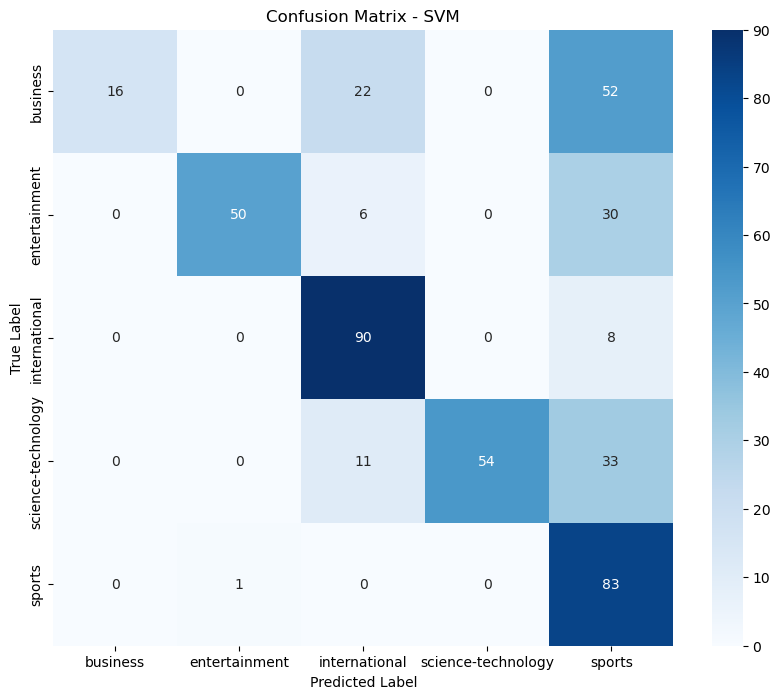

SVM Accuracy: 0.6425


In [23]:
accuracy_nn = evaluate_model(model, test_loader, device, int_to_label)